In [1]:
import random
import numpy as np
import math
import mesa
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import BaseScheduler
import pandas as pd
from SCN.agent import Order, Customer, Manufacturer, Supplier, manhattan_distance
from SCN.model import update_transport_cost_for_order, SupplyChainGridModel,calculate_unit_cost

In [2]:
df = pd.read_csv("SCN/supply_chain_data.csv")
df.rename(columns={"Stock levels": "inventory"}, inplace=True)
df["inventory"] = df["inventory"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df["Order quantities"] = df["Order quantities"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df = df[["inventory", "Order quantities"]]
inventory_count = df["inventory"].count()
order_qty_count = df["Order quantities"].count()
print("inventory 列数据个数（非空）:", inventory_count)
print("Order quantities 列数据个数（非空）:", order_qty_count)
print(df.head())
demands_list = df["Order quantities"].dropna().tolist()
inventory_list = df["inventory"].dropna().astype(int).tolist()
inventory_mean = df["inventory"].mean()
order_qty_mean = df["Order quantities"].mean()

print(f"Inventory 列的均值: {inventory_mean}")
print(f"Order quantities 列的均值: {order_qty_mean}")

inventory 列数据个数（非空）: 100
Order quantities 列数据个数（非空）: 100
   inventory  Order quantities
0         58                96
1         53                37
2          1                88
3         23                59
4          5                56
Inventory 列的均值: 47.77
Order quantities 列的均值: 49.22


In [3]:
df = pd.read_csv("SCN/DataCoSupplyChainDataset.csv", encoding="latin1")
df = df[["Customer Id", "Latitude", "Longitude"]]
df_unique = df.drop_duplicates()
df_sample = df_unique.sample(n=100, random_state=43)

# 3. 先利用 rank 得到初始坐标，保证原始数据不同对应不同数值
df_sample["x"] = df_sample["Latitude"].rank(method="dense", ascending=True).astype(int)
df_sample["y"] = df_sample["Longitude"].rank(method="dense", ascending=True).astype(int)

# 4. 将坐标缩放：简单的除以2，再取整，使数值变小
df_sample["x"] = np.ceil(df_sample["x"] / 5).astype(int)
df_sample["y"] = np.ceil(df_sample["y"] / 5).astype(int)

# 5. 去重：若缩放后出现多个点落在同一格，则只保留一条记录
df_final = df_sample.drop_duplicates(subset=["x", "y"])

# 6. 查看结果
print(df_final[["Customer Id", "Latitude", "Longitude", "x", "y"]])
print("Number of rows in df_final:", df_final.shape[0])
positions = df_final[["x", "y"]].values.tolist()

       Customer Id   Latitude   Longitude   x   y
55375         1672  34.077606 -117.240181  12   3
7248          4567  18.210739  -66.370605   1  15
16153        14473  38.611774 -121.282867  14   2
97197        17450  26.145800  -97.958252   7   6
71502        15468  34.748348  -77.428482  13  11
...            ...        ...         ...  ..  ..
18349         5509  33.702721  -84.269630  12   9
39398        10707  18.201599  -66.370529   1  16
65241         6022  39.963768  -75.606262  16  12
29264        13107  32.139179 -110.934845  10   4
31689         5951  33.604458 -111.990738  11   3

[70 rows x 5 columns]
Number of rows in df_final: 70


In [4]:
import networkx as nx

def get_weighted_edge_count(model):
    """
    构建一个 MultiGraph，将模型中所有代理作为节点，
    对于每个 delivered_orders 中已完成且已发货的订单，
    在发货方和收货方之间添加一条边，边的权重为订单数量。
    返回图中所有边的权重和，即为 weighted edge count。
    """
    G = nx.MultiGraph()
    for agent in model.schedule.agents:
        G.add_node(agent.unique_id)
    for order in model.delivered_orders:
        if order.completed and order.shipped and order.order_type == "product":
            # 添加边时指定 weight 属性为订单数量
            G.add_edge(order.sender_id, order.receiver_id, weight=order.quantity)
    total_weight = sum(data.get('weight', 1) for u, v, data in G.edges(data=True))
    return total_weight


In [9]:
cust_pos = [
  (16,5),(14,1),(18,14),(19,13),(1,17),(3,16),(7,17),(15,11),(1,16),
  (13,1),(19,4),(7,11),(19,8),(12,2),(8,6),(8,5),(14,2),(20,9),(1,14),
  (9,4),(3,17),(7,6),(11,3),(13,11),(18,12),(7,7),(17,14),(16,12),
  (16,10),(2,17),(9,5),(17,5),(4,17),(20,8),(4,15),(5,16)
]  
man_pos = [
  (10,3),(5,15),(9,6),(19,9),(2,16),(17,13)
]
sup_pos = [
  (3,14),(6,17),(2,14),(10,6),(16,8),(12,3),(11,2),(11,9),
  (2,15),(13,8),(12,9),(19,10),(7,10),(18,13)
]

Customer at (16, 5)
Customer at (14, 1)
Customer at (18, 14)
Customer at (19, 13)
Customer at (1, 17)
Customer at (3, 16)
Customer at (7, 17)
Customer at (15, 11)
Customer at (1, 16)
Customer at (13, 1)
Customer at (19, 4)
Customer at (7, 11)
Customer at (19, 8)
Customer at (12, 2)
Customer at (8, 6)
Customer at (8, 5)
Customer at (14, 2)
Customer at (20, 9)
Customer at (1, 14)
Customer at (9, 4)
Customer at (3, 17)
Customer at (7, 6)
Customer at (11, 3)
Customer at (13, 11)
Customer at (18, 12)
Customer at (7, 7)
Customer at (17, 14)
Customer at (16, 12)
Customer at (16, 10)
Customer at (2, 17)
Customer at (9, 5)
Customer at (17, 5)
Customer at (4, 17)
Customer at (20, 8)
Customer at (4, 15)
Customer at (5, 16)
Manufacturer at (10, 3)
Manufacturer at (5, 15)
Manufacturer at (9, 6)
Manufacturer at (19, 9)
Manufacturer at (2, 16)
Manufacturer at (17, 13)
Supplier at (3, 14)
Supplier at (6, 17)
Supplier at (2, 14)
Supplier at (10, 6)
Supplier at (16, 8)
Supplier at (12, 3)
Supplier at (1

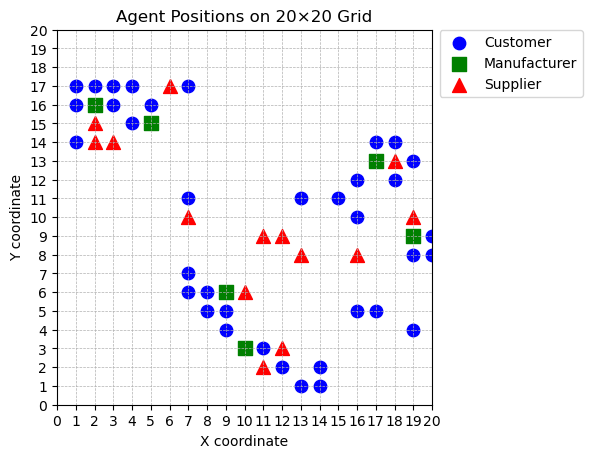

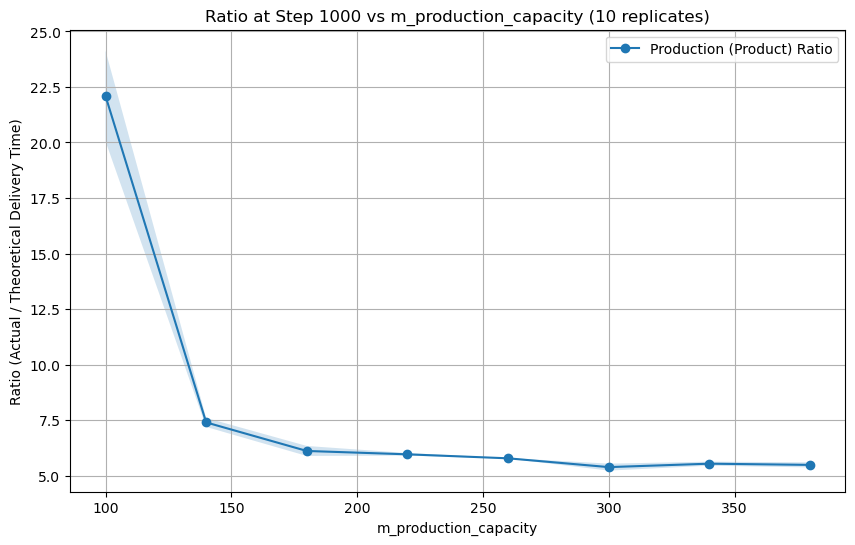

In [10]:
total_steps = 500
num_replicates = 2
m_production_values = range(100,420,40)
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表
mat_results = []   # 每个 m_production_capacity 下的 material ratio 列表
ratio_vals = [m_prod / 400 for m_prod in m_production_values]
for m_prod in m_production_values:
    prod_list = []
    mat_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(cust_positions=cust_pos,
                 man_positions=man_pos,
                 sup_positions=sup_pos,
                 demands_list=demands_list,
                 inventory_list=inventory_list,                 
                 cust_demand_multiplier=1.0,
                 m_production_capacity=m_prod,
                 m_inventory_capacity_product=400,
                 m_inventory_capacity_material=800,
                 s_material_capacity=240,
                 agent_mode="homogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
                 logistics_speed=2.0,
                 rm_procurement_mode="gap_based",
                 rm_reorder_point=400,
                 rm_reorder_target=800,
                 rm_purchase_multiplier=1.5,
                 rm_produce_multiplier=1.5,
                 product_order_mode="normal",
                 material_order_mode="normal",
                 num_customers=36,
                 num_manufacturers=6,
                 num_suppliers=14)
        for t in range(1, total_steps+1):
            model.step()
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time is not None]
        sum_actual_prod = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical_prod = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual_prod / sum_theoretical_prod if sum_theoretical_prod > 0 else None
        prod_list.append(ratio_prod if ratio_prod is not None else 0)
    prod_results.append(prod_list)
cust_pos = [c.pos for c in model.customers]
man_pos  = [m.pos for m in model.manufacturers]
sup_pos  = [s.pos for s in model.suppliers]   
for x,y in cust_pos:
    print("Customer at", (x,y))
for x,y in man_pos:
    print("Manufacturer at", (x,y))
for x,y in sup_pos:
    print("Supplier at", (x,y))
# 拆分成 x 和 y
cust_x, cust_y = zip(*cust_pos)
man_x,  man_y  = zip(*man_pos)
sup_x,  sup_y  = zip(*sup_pos)

fig, ax = plt.subplots(figsize=(6,6))

# 散点
ax.scatter(cust_x, cust_y, c='blue',  marker='o', s= 80, label='Customer')
ax.scatter(man_x,  man_y, c='green', marker='s', s=100, label='Manufacturer')
ax.scatter(sup_x,  sup_y, c='red',   marker='^', s=100, label='Supplier')

# 坐标轴和网格
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xticks(range(21))
ax.set_yticks(range(21))
ax.grid(True, linestyle='--', linewidth=0.5)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Agent Positions on 20×20 Grid')

# 强制保持子图为正方形
ax.set_aspect('equal', adjustable='box')

# 图例放到外面
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# 收紧子图右边距，给图例留出空间
plt.subplots_adjust(right=0.75)

plt.show()



# 计算均值和标准差
prod_means = [np.mean(x) for x in prod_results]
prod_stds = [np.std(x) for x in prod_results]

plt.figure(figsize=(10,6))
x = np.array(list(m_production_values))
prod_means = np.array(prod_means)
prod_stds = np.array(prod_stds)
plt.plot(x, prod_means, 'o-', label='Production (Product) Ratio')
plt.fill_between(x, prod_means - prod_stds, prod_means + prod_stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs m_production_capacity (10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
total_steps = 1000
num_replicates = 10
m_production_values = range(20,150,5)
s_material_capacity = 400  # 你的固定物料能力
num_manufacturers=6
num_suppliers=4
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表

for m_prod in m_production_values:
    prod_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            positions=positions,
            demands_list=demands_list,
            inventory_list=inventory_list,                 
            cust_demand_multiplier=1.0,
            m_production_capacity=m_prod,
            m_inventory_capacity_product=300,
            m_inventory_capacity_material=600,
            s_material_capacity=s_material_capacity,
            m_cap_mode="homogeneous",
            logistics_speed=2.0,
            rm_procurement_mode="gap_based",
            rm_reorder_point=300,
            rm_reorder_target=600,
            rm_purchase_multiplier=1.1,
            rm_produce_multiplier=1.1,
            product_order_mode="normal",
            material_order_mode="normal",
            num_customers=20,
            num_manufacturers=6,
            num_suppliers=4
        )
        for t in range(1, total_steps+1):
            model.step()
        # 统计 delivered_orders 中的 product
        prod_orders = [
            o for o in model.delivered_orders
            if o.order_type=="product" and o.actual_delivery_time is not None
        ]
        sum_actual = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual / sum_theoretical if sum_theoretical>0 else 0
        prod_list.append(ratio_prod)
    prod_results.append(prod_list)

# 计算均值和标准差
prod_means = np.array([np.mean(lst) for lst in prod_results])
prod_stds  = np.array([np.std(lst)  for lst in prod_results])

# 这里算出“生产能力/物料能力”的比值
ratio_vals = np.array([(m_prod*num_manufacturers)/(s_material_capacity*num_suppliers)for m_prod in m_production_values])

plt.figure(figsize=(10,6))
plt.plot(ratio_vals, prod_means, 'o-')
plt.fill_between(ratio_vals,
                 prod_means - prod_stds,
                 prod_means + prod_stds,
                 alpha=0.2)
plt.xlabel('m_production_capacity/s_material_capacity')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs Production / Material Capacity Ratio(10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


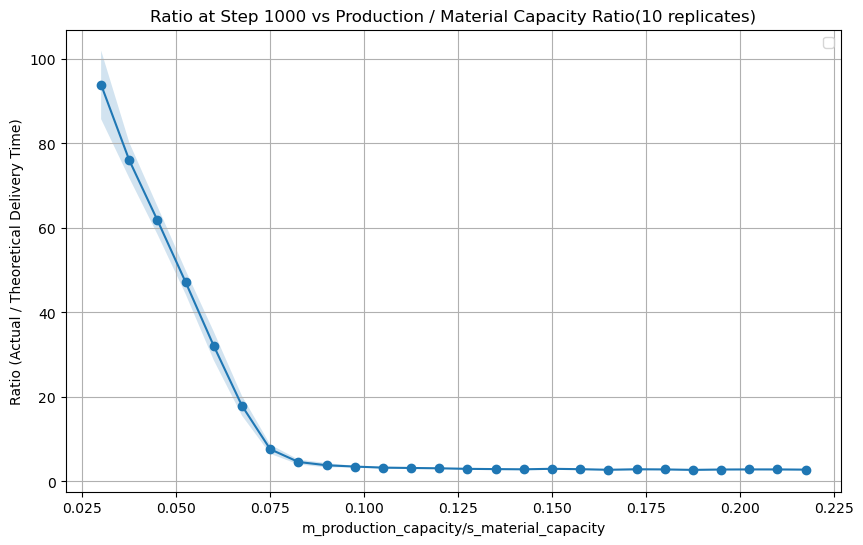

In [26]:
total_steps = 1000
num_replicates = 10
m_production_values = range(20,150,5)
s_material_capacity = 1000  # 你的固定物料能力
num_manufacturers=6
num_suppliers=4
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表

for m_prod in m_production_values:
    prod_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            positions=positions,
            demands_list=demands_list,
            inventory_list=inventory_list,                 
            cust_demand_multiplier=1.0,
            m_production_capacity=m_prod,
            m_inventory_capacity_product=300,
            m_inventory_capacity_material=600,
            s_material_capacity=s_material_capacity,
            m_cap_mode="homogeneous",
            logistics_speed=2.0,
            rm_procurement_mode="gap_based",
            rm_reorder_point=300,
            rm_reorder_target=600,
            rm_purchase_multiplier=1.1,
            rm_produce_multiplier=1.1,
            product_order_mode="normal",
            material_order_mode="normal",
            num_customers=20,
            num_manufacturers=6,
            num_suppliers=4
        )
        for t in range(1, total_steps+1):
            model.step()
        # 统计 delivered_orders 中的 product
        prod_orders = [
            o for o in model.delivered_orders
            if o.order_type=="product" and o.actual_delivery_time is not None
        ]
        sum_actual = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual / sum_theoretical if sum_theoretical>0 else 0
        prod_list.append(ratio_prod)
    prod_results.append(prod_list)

# 计算均值和标准差
prod_means = np.array([np.mean(lst) for lst in prod_results])
prod_stds  = np.array([np.std(lst)  for lst in prod_results])

# 这里算出“生产能力/物料能力”的比值
ratio_vals = np.array([(m_prod*num_manufacturers)/(s_material_capacity*num_suppliers)for m_prod in m_production_values])

plt.figure(figsize=(10,6))
plt.plot(ratio_vals, prod_means, 'o-')
plt.fill_between(ratio_vals,
                 prod_means - prod_stds,
                 prod_means + prod_stds,
                 alpha=0.2)
plt.xlabel('m_production_capacity/s_material_capacity')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs Production / Material Capacity Ratio(10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


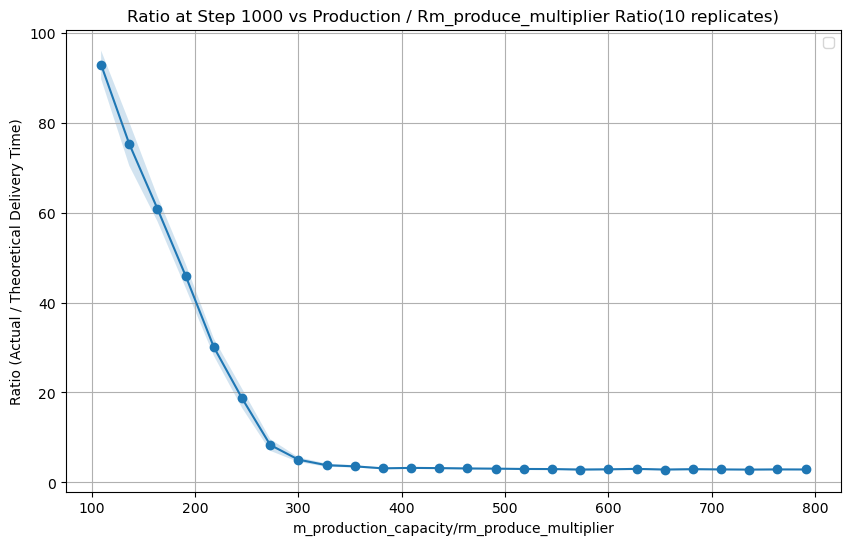

In [28]:
total_steps = 1000
num_replicates = 10
m_production_values = range(20,150,5)
rm_produce_multiplier = 1.1  # 你的固定物料能力
num_manufacturers=6
num_suppliers=4
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表

for m_prod in m_production_values:
    prod_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            positions=positions,
            demands_list=demands_list,
            inventory_list=inventory_list,                 
            cust_demand_multiplier=1.0,
            m_production_capacity=m_prod,
            m_inventory_capacity_product=300,
            m_inventory_capacity_material=600,
            s_material_capacity=400,
            m_cap_mode="homogeneous",
            logistics_speed=2.0,
            rm_procurement_mode="gap_based",
            rm_reorder_point=300,
            rm_reorder_target=600,
            rm_purchase_multiplier=1.1,
            rm_produce_multiplier=rm_produce_multiplier,
            product_order_mode="normal",
            material_order_mode="normal",
            num_customers=20,
            num_manufacturers=6,
            num_suppliers=4
        )
        for t in range(1, total_steps+1):
            model.step()
        # 统计 delivered_orders 中的 product
        prod_orders = [
            o for o in model.delivered_orders
            if o.order_type=="product" and o.actual_delivery_time is not None
        ]
        sum_actual = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual / sum_theoretical if sum_theoretical>0 else 0
        prod_list.append(ratio_prod)
    prod_results.append(prod_list)

# 计算均值和标准差
prod_means = np.array([np.mean(lst) for lst in prod_results])
prod_stds  = np.array([np.std(lst)  for lst in prod_results])

# 这里算出“生产能力/物料能力”的比值
ratio_vals = np.array([(m_prod*num_manufacturers)/(rm_produce_multiplier)for m_prod in m_production_values])

plt.figure(figsize=(10,6))
plt.plot(ratio_vals, prod_means, 'o-')
plt.fill_between(ratio_vals,
                 prod_means - prod_stds,
                 prod_means + prod_stds,
                 alpha=0.2)
plt.xlabel('m_production_capacity/rm_produce_multiplier')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs Production / Rm_produce_multiplier Ratio(10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

Scan m_prod: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [29:36<00:00, 88.81s/it]


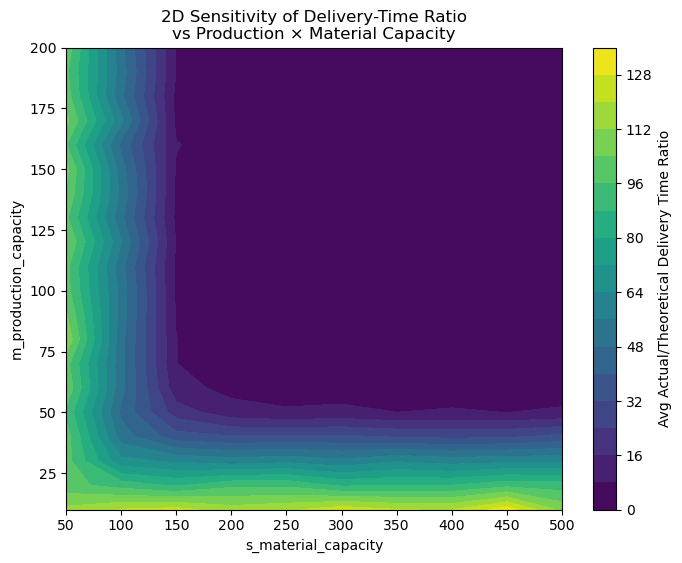

In [23]:
from tqdm import tqdm
TOTAL_STEPS     = 1000
NUM_REPLICATES  = 2
NUM_SUPPLIERS   = 4
NUM_MANUFACTURERS = 6

# 扫描范围
m_vals = np.arange(10, 201, 10)   # 生产能力 从 10 到 200，每 10 一步
s_vals = np.arange(50, 501, 50)   # 物料能力 从 50 到 500，每 50 一步

results = np.zeros((len(m_vals), len(s_vals)))

# 双重循环
for i, m_prod in enumerate(tqdm(m_vals, desc="Scan m_prod")):
    for j, s_mat in enumerate(tqdm(s_vals, desc="Scan s_mat", leave=False)):
        ratios = []
        for rep in range(NUM_REPLICATES):
            model = SupplyChainGridModel(
                positions=positions,
                demands_list=demands_list,
                inventory_list=inventory_list,
                cust_demand_multiplier=1.0,
                m_production_capacity=m_prod,
                m_inventory_capacity_product=300,
                m_inventory_capacity_material=600,
                s_material_capacity=s_mat,
                m_cap_mode="homogeneous",
                logistics_speed=2.0,
                rm_procurement_mode="gap_based",
                rm_reorder_point=300,
                rm_reorder_target=600,
                rm_purchase_multiplier=1.1,
                rm_produce_multiplier=1.1,
                product_order_mode="normal",
                material_order_mode="normal",
                num_customers=20,
                num_manufacturers=NUM_MANUFACTURERS,
                num_suppliers=NUM_SUPPLIERS
            )
            # 运行若干步
            for _ in range(TOTAL_STEPS):
                model.step()

            # 收集所有已完成的“产品”订单
            prod_orders = [
                o for o in model.delivered_orders
                if o.order_type=="product" and o.actual_delivery_time is not None
            ]
            actual   = sum(o.actual_delivery_time   for o in prod_orders)
            theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
            ratio = (actual / theoretical) if theoretical>0 else 0
            ratios.append(ratio)

        results[i, j] = np.mean(ratios)
        
# 绘制等高线填色图
X, Y = np.meshgrid(s_vals, m_vals)  # X 轴：s_material_capacity, Y 轴：m_production_capacity

plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, results, levels=20, cmap="viridis")
plt.colorbar(cp, label="Avg Actual/Theoretical Delivery Time Ratio")
plt.xlabel("s_material_capacity")
plt.ylabel("m_production_capacity")
plt.title("2D Sensitivity of Delivery‐Time Ratio\nvs Production × Material Capacity")
plt.show()

In [ ]:
def run_simulation(heterogeneous=False, m_prod_value=None, total_steps=1000, num_reps=5):
    """
    若 heterogeneous==False，则采用 uniform 模式，m_prod_value为统一生产能力；
    若 heterogeneous==True，则每个manufacturer随机取值于 [m_prod_value-5, m_prod_value+5]。
    返回：均值、产品订单ratio、原材料订单ratio、制造商状态N的累计频次。
    """
    ratio_prod_list = []
    ratio_mat_list = []
    statusN_freq_list = []
    capacity_means = []
    for rep in range(num_reps):
        used_positions.clear()
        if heterogeneous:
            model = SupplyChainGridModel(positions,             
                 demands_list,          
                 inventory_list,        
                 num_customers=10,
                 num_manufacturers=6,
                 num_suppliers=2,
                 cust_demand_probability=0.4,
                 m_production_capacity=m_prod,
                 m_inventory_capacity=1000,
                 s_material_capacity=300, heterogeneous=True)
            caps = [m.production_capacity for m in model.manufacturers]
            capacity_means.append(np.mean(caps))
        else:
            model = SupplyChainGridModel(positions,             
                 demands_list,          
                 inventory_list,        
                 num_customers=10,
                 num_manufacturers=6,
                 num_suppliers=2,
                 cust_demand_probability=0.4,
                 m_production_capacity=m_prod,
                 m_inventory_capacity=1000,
                 s_material_capacity=300, heterogeneous=False)
            capacity_means.append(m_prod_value)
        statusN_freq = 0
        for t in range(1, total_steps+1):
            model.step()
            statusN_freq += sum(1 for m in model.manufacturers if m.status == 'N')
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time is not None]
        sum_actual_prod = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical_prod = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual_prod / sum_theoretical_prod if sum_theoretical_prod > 0 else 0
        ratio_prod_list.append(ratio_prod)
        statusN_freq_list.append(statusN_freq)
    return np.mean(capacity_means), np.mean(ratio_prod_list), np.mean(statusN_freq_list)

# 对于 uniform 模式，m_prod_value 取 5~30 的每个整数
uniform_targets = list(range(5, 30))
uni_caps = []
uni_prod_ratios = []
uni_mat_ratios = []
uni_statusN = []

for m_prod in uniform_targets:
    cap_mean, rprod, statusN = run_simulation(heterogeneous=False, m_prod_value=m_prod, total_steps=1000, num_reps=10)
    uni_caps.append(cap_mean)
    uni_prod_ratios.append(rprod)
    uni_statusN.append(statusN)
    print(f"Uniform m_prod = {m_prod}: cap_mean={cap_mean}, prod ratio={rprod}, status N freq={statusN}")

# 对于 heterogeneous 模式，目标均值取 5~16，每个 manufacturer 随机取值于 [target-5, target+5]
hetero_caps = []
hetero_prod_ratios = []
hetero_statusN = []

for target in uniform_targets:
    reps = 10
    hetero_prod_list = []
    hetero_statusN_list = []
    caps_list = []
    for rep in range(reps):
        used_positions.clear()
        # 对每个 manufacturer，随机取值于 [target-5, target+5]
        num_manufacturers = 6
        manufacturers_caps = [random.randint(max(1, target-10), target+10) for _ in range(num_manufacturers)]
        model = SupplyChainGridModel(positions,             
                 demands_list,          
                 inventory_list,        
                 num_customers=10,
                 num_manufacturers=6,
                 num_suppliers=2,
                 cust_demand_probability=0.4,
                 m_production_capacity=target,
                 m_inventory_capacity=1000,
                 s_material_capacity=300, heterogeneous=False)
        # 替换每个 Manufacturer 的生产能力为随机值
        for i, m in enumerate(model.manufacturers):
            m.production_capacity = manufacturers_caps[i]
        caps_list.append(np.mean(manufacturers_caps))
        statusN_freq = 0
        for t in range(1, 1000+1):
            model.step()
            statusN_freq += sum(1 for m in model.manufacturers if m.status == 'N')
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time is not None]
        sum_actual_prod = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical_prod = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual_prod / sum_theoretical_prod if sum_theoretical_prod > 0 else 0
        hetero_prod_list.append(ratio_prod)
        hetero_statusN_list.append(statusN_freq)
    hetero_caps.append(np.mean(caps_list))
    hetero_prod_ratios.append(np.mean(hetero_prod_list))
    hetero_statusN.append(np.mean(hetero_statusN_list))
    print(f"Hetero target = {target}: cap_mean={np.mean(caps_list):.2f}, prod ratio={np.mean(hetero_prod_list):.3f}, status N freq={np.mean(hetero_statusN_list):.1f}")

# 绘制比值图
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
x = np.array(uniform_targets)
plt.errorbar(x, uni_prod_ratios, fmt='o-', label='Uniform Product Ratio')
plt.errorbar(x, hetero_prod_ratios, fmt='o--', label='Hetero Product Ratio')
plt.xlabel('Mean Production Capacity')
plt.ylabel('Ratio (Actual/Theoretical Delivery Time)')
plt.title('Ratio at Step 1000')
plt.legend()
plt.grid(True)

# 绘制状态 N 频次图
plt.subplot(1,2,2)
plt.plot(x, uni_statusN, 'o-', label='Uniform Mode')
plt.plot(x, hetero_statusN, 's--', label='Hetero Mode')
plt.xlabel('Mean Production Capacity')
plt.ylabel('Accumulated Manufacturer N Frequency (1000 steps)')
plt.title('Manufacturer Status N Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()